In this notebook we do spatial interpolation of CML rainfall data and compare IDW and Kriging, each with different parameters. Before we can do the spatial interpolation we first have to process the example CML data.

In [1]:
import pycomlink as pycml
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr

# Load example CML data

In [2]:
cmls = xr.open_dataset(pycml.io.examples.get_example_data_path() + '/example_cml_data.nc')
cmls

<xarray.Dataset>
Dimensions:           (time: 15840, cml_id: 500, channel_id: 2)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:59:00
  * cml_id            (cml_id) object '0' '1' '2' '3' ... '497' '498' '499'
    length            (cml_id) float64 ...
    site_a_latitude   (cml_id) float64 ...
    site_a_longitude  (cml_id) float64 ...
    site_b_latitude   (cml_id) float64 ...
    site_b_longitude  (cml_id) float64 ...
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 ...
    polarization      (cml_id, channel_id) object ...
Data variables:
    rsl               (channel_id, cml_id, time) float32 ...
    tsl               (channel_id, cml_id, time) float32 ...

# Set fill values to NaN and interpolate short gaps

In [3]:
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['trsl'] = cmls.tsl - cmls.rsl

cmls['trsl'] = cmls.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')

# Do standard processing

We do a standard processing in this notebook without any explanation to quickly get CML rainfall estimates for interpolaton. For more details on the processing, check out the notebook on the basic CML processing workflow.

In [4]:
cmls['wet'] = cmls.trsl.rolling(time=60, center=True).std(skipna=False) > 0.8

cmls['wet_fraction'] = (cmls.wet==1).sum(dim='time') / len(cmls.time)

cmls['baseline'] = pycml.processing.baseline.baseline_constant(
    trsl=cmls.trsl, 
    wet=cmls.wet, 
    n_average_last_dry=5,
)
cmls['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cmls.trsl, 
    baseline=cmls.baseline, 
    wet=cmls.wet, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)
cmls['A'] = cmls.trsl - cmls.baseline - cmls.waa

cmls['A'].values[cmls.A < 0] = 0

cmls['R'] = pycml.processing.k_R_relation.calc_R_from_A(
    A=cmls.A, L_km=cmls.length.values.astype('float'), f_GHz=cmls.frequency/1e9, pol=cmls.polarization
)

# Aggregate to hourly rainfall sums

We do this by taking the hourly mean of the 1-minute rainfall rates of the CML data

In [5]:
cmls_R_1h = cmls.R.resample(time='1h', label='right').mean().to_dataset()
cmls_R_1h

<xarray.Dataset>
Dimensions:           (cml_id: 500, channel_id: 2, time: 264)
Coordinates:
  * cml_id            (cml_id) object '0' '1' '2' '3' ... '497' '498' '499'
    length            (cml_id) float64 6.179 5.673 7.52 ... 8.472 14.57 4.994
    site_a_latitude   (cml_id) float64 58.26 58.09 58.19 ... 57.51 57.77 57.07
    site_a_longitude  (cml_id) float64 1.388 1.637 1.359 ... 2.022 1.471 2.09
    site_b_latitude   (cml_id) float64 58.25 58.13 58.21 ... 57.47 57.83 57.07
    site_b_longitude  (cml_id) float64 1.304 1.59 1.461 ... 2.118 1.298 2.023
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 2.491e+10 ... 2.598e+10
    polarization      (cml_id, channel_id) object 'V' 'V' 'H' ... 'V' 'V' 'V'
  * time              (time) datetime64[ns] 2018-05-10T01:00:00 ... 2018-05-21
Data variables:
    R                 (channel_id, cml_id, time) float64 0.0 0.0 0.0 ... 0.0 0.0

# Calculate center point of each CML

We need this for the simple interpolatoin approaches that are used in this notebook which do simple interpolation of the rainfall values based on the center point of each CML.

In [6]:
cmls_R_1h['lat_center'] = (cmls_R_1h.site_a_latitude + cmls_R_1h.site_b_latitude)/2
cmls_R_1h['lon_center'] = (cmls_R_1h.site_a_longitude + cmls_R_1h.site_b_longitude)/2

# Function definition for quick plotting of CML paths

In [7]:
def plot_cml_lines(ds_cmls, ax):
    ax.plot(
        [ds_cmls.site_a_longitude, ds_cmls.site_b_longitude],
        [ds_cmls.site_a_latitude, ds_cmls.site_b_latitude],
        'k',
        linewidth=1,
    )

# Do interpolation with IDW for rainfall sum per CML over example period

The folowing cell prepares the interpolator object.

In [8]:
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15, 
    p=2, 
    exclude_nan=True, 
    max_distance=0.3,
)

Do the interpolation by calling the interpolator object.

In [9]:
R_grid = idw_interpolator(
    x=cmls_R_1h.lon_center, 
    y=cmls_R_1h.lat_center, 
    z=cmls_R_1h.R.isel(channel_id=1).sum(dim='time').where(cmls.isel(channel_id=1).wet_fraction < 0.3), 
    resolution=0.01,
)

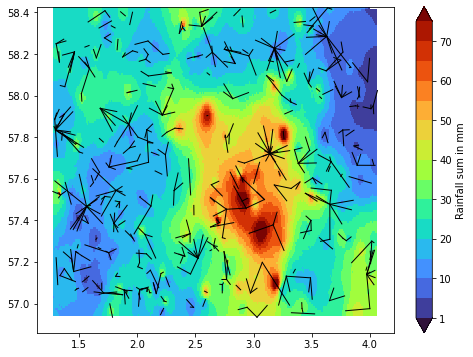

In [10]:
bounds = np.arange(0, 80, 5.0)
bounds[0] = 1
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

fig, ax = plt.subplots(figsize=(8, 6))
pc = plt.pcolormesh(
    idw_interpolator.xgrid, 
    idw_interpolator.ygrid, 
    R_grid, 
    shading='nearest', 
    cmap='turbo',
    norm=norm,
)
plot_cml_lines(cmls_R_1h, ax=ax)
fig.colorbar(pc, label='Rainfall sum in mm');

# Compare IDW and Kriging for different parameters

Here we use CML rainfall sum for one hour. Note that we exclude (by setting their result to NaN) CMLs that have a too high (0.3) wet_fraction.

In [11]:
cmls_hour_selected = cmls_R_1h.R.isel(channel_id=1).isel(time=92).where(cmls.isel(channel_id=1).wet_fraction < 0.3)

The following cell defines the plotting functions and the colorscale

In [12]:
bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20] 
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
cmap = plt.get_cmap('turbo').copy()
cmap.set_under('w')


def idw_interpolate_and_plot(ax, nnear=15, p=2, max_distance=0.3):

    idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
        nnear=nnear, 
        p=p, 
        exclude_nan=True, 
        max_distance=max_distance,
    )

    R_grid = idw_interpolator(
        x=cmls_R_1h.lon_center, 
        y=cmls_R_1h.lat_center, 
        z=cmls_hour_selected,
        resolution=0.01,
    )

    pc = ax.pcolormesh(
        idw_interpolator.xgrid, 
        idw_interpolator.ygrid, 
        R_grid, 
        shading='nearest', 
        cmap=cmap,
        norm=norm,
    )
    ax.set_title(f'nnear={nnear} p={p}\nmax_distance={max_distance}')

    plot_cml_lines(cmls_R_1h, ax=ax)
    return pc


def kriging_interpolate_and_plot(
    ax, 
    nlags=6, 
    variogram_model='spherical', 
    n_closest_points=None, 
    variogram_parameters=None,
):

    kriging_interpolator = pycml.spatial.interpolator.OrdinaryKrigingInterpolator(
        nlags=nlags,
        variogram_model=variogram_model,
        variogram_parameters=variogram_parameters,
        weight=True,
        n_closest_points=n_closest_points,
    )

    R_grid = kriging_interpolator(
        x=cmls_R_1h.lon_center, 
        y=cmls_R_1h.lat_center, 
        z=cmls_hour_selected,
        resolution=0.01,
    )

    pc = ax.pcolormesh(
        idw_interpolator.xgrid, 
        idw_interpolator.ygrid, 
        R_grid, 
        shading='nearest', 
        cmap=cmap,
        norm=norm,
    )
    if variogram_parameters is None:
        ax.set_title(f'nlags={nlags} variogram_model={variogram_model}\nn_closest_points={n_closest_points}')
    else:
        ax.set_title(f'variogram_model={variogram_model}\n{variogram_parameters}')

    plot_cml_lines(cmls_R_1h, ax=ax)
    return pc

The code below plots 4 different variants of IDW and Kriging using different parameters.

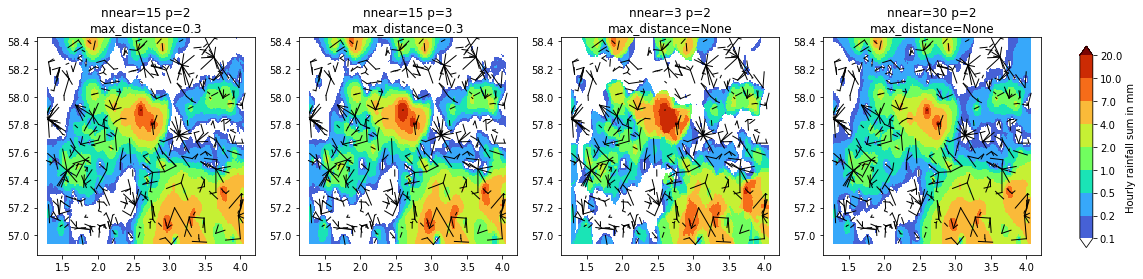

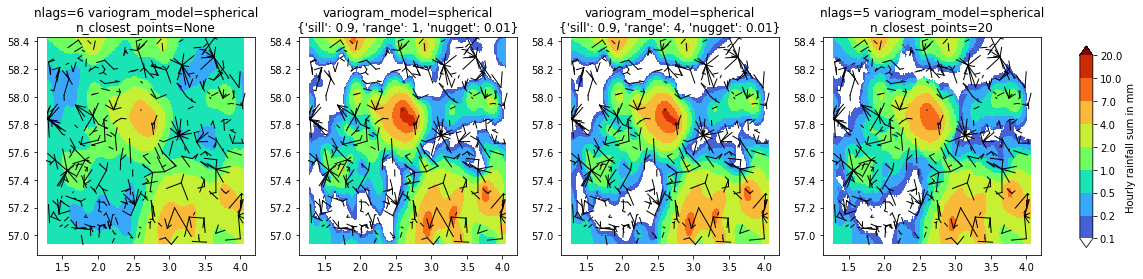

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

idw_interpolate_and_plot(ax=axs[0], nnear=15, p=2, max_distance=0.3)
idw_interpolate_and_plot(ax=axs[1], nnear=15, p=3, max_distance=0.3)
idw_interpolate_and_plot(ax=axs[2], nnear=3, p=2, max_distance=None)
pc = idw_interpolate_and_plot(ax=axs[3], nnear=30, p=2, max_distance=None)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cb = fig.colorbar(pc, cax=cbar_ax, label='Hourly rainfall sum in mm', );


fig, axs = plt.subplots(1, 4, figsize=(18, 4))

kriging_interpolate_and_plot(ax=axs[0])
kriging_interpolate_and_plot(ax=axs[1], variogram_parameters={'sill': 0.9, 'range': 1, 'nugget': 0.01})
kriging_interpolate_and_plot(ax=axs[2], variogram_parameters={'sill': 0.9, 'range': 4, 'nugget': 0.01})
pc = kriging_interpolate_and_plot(ax=axs[3], nlags=5, variogram_model='spherical', n_closest_points=20)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cb = fig.colorbar(pc, cax=cbar_ax, label='Hourly rainfall sum in mm', );